# Raw  Y variable and its processing
This notebook has two functions:
1. download original Y, crude oil price, from Quandl of all dates available
2. process original Y into more possible direct Ys, and Y-based input variables

# Function 1

In [336]:
import quandl

In [4]:
import numpy as np
import pandas as pd

In [4]:
quandl.ApiConfig.api_key = 'GFC1VTVV3SXKRmR9w-mr'
output = quandl.get("EIA/PET_RWTC_D")

In [9]:
output.head()

,Value
Date,
1986-01-02,25.56
1986-01-03,26.00
1986-01-06,26.53
1986-01-07,25.85
1986-01-08,25.87


In [28]:
output.to_csv('WTICrudeOilPrice.csv')

# Function 2
Before generating Ys and Y-based Xs, daily return,r(t), is calculated at every t:

            r(t) = P(t)/P(t-1) - 1

12 input variables are generated, shown as the following:

            previous-n-month-daily-average-return = mean([r(t-n*30) to r(t-1)])
            previous-n-month-daily-return-volatility = std([r(t-n*30) to r(t-1)])
            previous-n-month-daily-return-range = min([r(t-n*30) to r(t-1)]),max([r(t-n*30) to r(t-1)])
            n = 1,2,3,6
Similarly, 8 Y variables are calculated as the following:

            next-n-month-daily-average-return = mean([r(t+1) to r(t+30*n)])
            next-n-month-daily-return-volatility = std([r(t+1) to r(t+30*n)])

In [5]:
data = pd.read_csv('WTICrudeOilPrice.csv')
data.head()

,Date,Value
0,1986-01-02,25.56
1,1986-01-03,26.00
2,1986-01-06,26.53
3,1986-01-07,25.85
4,1986-01-08,25.87


In [6]:
data['Date'].is_unique

True

In [7]:
type(data['Date'])

pandas.core.series.Series

In [8]:
data['Date'] = pd.to_datetime(data['Date'])

In [9]:
data['Date'].head()

0   1986-01-02
1   1986-01-03
2   1986-01-06
3   1986-01-07
4   1986-01-08
Name: Date, dtype: datetime64[ns]

In [10]:
data = data.set_index('Date')

In [11]:
data['20100101':'20100202']

,Value
Date,
2010-01-04,81.52
2010-01-05,81.74
2010-01-06,83.12
2010-01-07,82.60
2010-01-08,82.74
2010-01-11,82.54
2010-01-12,80.79
2010-01-13,79.66
2010-01-14,79.35


In [12]:
data.rename(columns={'Value':'Price'},inplace=True)

Calculate r(t)

In [13]:
### try calculate r(t)
data.head()/data.head().shift(1) - 1 

,Price
Date,
1986-01-02,NaN
1986-01-03,0.017214
1986-01-06,0.020385
1986-01-07,-0.025631
1986-01-08,0.000774


In [14]:
### Daily_Return is calculated by P(t)/P(t-1) - 1
data['Daily_Return'] = data['Price']/data['Price'].shift(1) - 1
data.head()

,Price,Daily_Return
Date,,
1986-01-02,25.56,NaN
1986-01-03,26.00,0.017214
1986-01-06,26.53,0.020385
1986-01-07,25.85,-0.025631
1986-01-08,25.87,0.000774


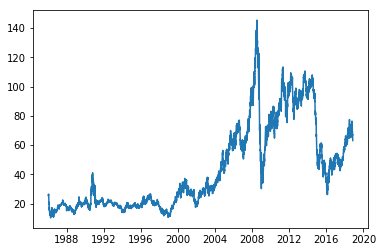

In [16]:
import matplotlib.pyplot as plt
plt.plot(data['Price'])
plt.show()

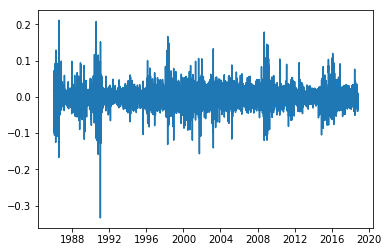

In [17]:
plt.plot(data['Daily_Return'])
plt.show()

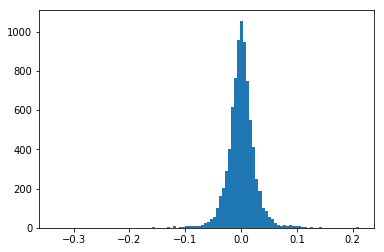

In [18]:
plt.hist(data['Daily_Return'][1:],bins=100) # the first is NA
plt.show()

In [21]:
import datetime

In [22]:
def MovingAvg(DATA, tLength, FUN, title,pre=True):
    ### DATA is a series with time index, 
    ### tLength is the time lenght, 
    ### FUN is the function working over the series
    ### title is the name of the output for this function
    ### pre is to decide to look forward or backward of the time series
    ### output is a dataframe with time index of DATA, and column, named with title
    
    ### pandas and numpy should be loaded in advance
    tPoints = DATA.index
    outputDf = pd.DataFrame(index=tPoints,columns=[title])
    for t in tPoints:
        if pre:
            startT = t - datetime.timedelta(tLength+1)
            endT = t - datetime.timedelta(1)
        else:
            startT = t + datetime.timedelta(1)
            endT = t + datetime.timedelta(tLength+1)
        #print('time t:',t)
        temp_output = FUN(DATA[startT:endT])
        outputDf.loc[t,title] = temp_output
        if pre:
            outputDf.iloc[:tLength,0] = np.nan ### the first tLength-days data is not involved in the data
        else:
            outputDf.iloc[-tLength:,0] = np.nan
    return outputDf


Calculate Previous-1-Month-Avg-Daily-Return and regrading Volatility, and look the graph to make sure the algo runs correctly

In [23]:
Pre1MonthAvgDailyRet = MovingAvg(data['Daily_Return'],30,np.nanmean,'Pre1MonthAvgDailyRet')
Pre1MonthVolDaily = MovingAvg(data['Daily_Return'],30,np.nanstd,'Pre1MonthVolDaily')

C:\Users\fzhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
C:\Users\fzhan\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1545: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [24]:
len(Pre1MonthAvgDailyRet)

8296

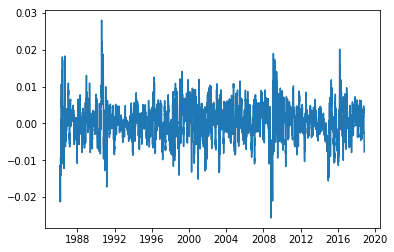

In [25]:
plt.plot(Pre1MonthAvgDailyRet)
plt.show()

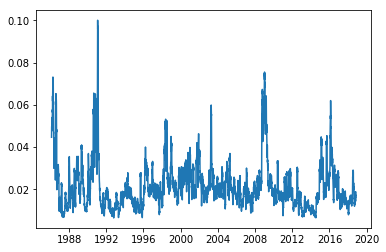

In [26]:
plt.plot(Pre1MonthVolDaily)
plt.show()

In [27]:
data_OUT = data.join([Pre1MonthAvgDailyRet,Pre1MonthVolDaily])
data_OUT.iloc[20:40,:]

,Price,Daily_Return,Pre1MonthAvgDailyRet,Pre1MonthVolDaily
Date,,,,
1986-01-30,19.58,-0.001530,NaN,NaN
1986-01-31,18.95,-0.032176,NaN,NaN
1986-02-03,17.42,-0.080739,NaN,NaN
1986-02-04,15.58,-0.105626,NaN,NaN
1986-02-05,16.28,0.044929,NaN,NaN
1986-02-06,16.60,0.019656,NaN,NaN
1986-02-07,17.70,0.066265,NaN,NaN
1986-02-10,16.78,-0.051977,NaN,NaN
1986-02-11,16.28,-0.029797,NaN,NaN


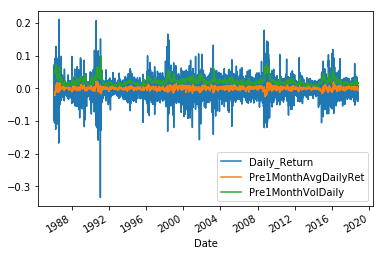

In [28]:
data_OUT.iloc[:,1:].plot()
plt.show()

Calculate the input Y-based X for n = 2,3,6

In [29]:
Pre2MonthAvgDailyRet = MovingAvg(data['Daily_Return'],60,np.nanmean,'Pre2MonthAvgDailyRet')
Pre2MonthVolDaily = MovingAvg(data['Daily_Return'],60,np.nanstd,'Pre2MonthVolDaily')
Pre3MonthAvgDailyRet = MovingAvg(data['Daily_Return'],90,np.nanmean,'Pre3MonthAvgDailyRet')
Pre3MonthVolDaily = MovingAvg(data['Daily_Return'],90,np.nanstd,'Pre3MonthVolDaily')
Pre6MonthAvgDailyRet = MovingAvg(data['Daily_Return'],180,np.nanmean,'Pre6MonthAvgDailyRet')
Pre6MonthVolDaily = MovingAvg(data['Daily_Return'],180,np.nanstd,'Pre6MonthVolDaily')

C:\Users\fzhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
C:\Users\fzhan\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1545: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [30]:
data_OUT2 = data.join([Pre1MonthAvgDailyRet,Pre2MonthAvgDailyRet,Pre3MonthAvgDailyRet,Pre6MonthAvgDailyRet,
                      Pre1MonthVolDaily,Pre2MonthVolDaily,Pre3MonthVolDaily,Pre6MonthVolDaily])
data_OUT2.iloc[20:40,:]

,Price,Daily_Return,Pre1MonthAvgDailyRet,Pre2MonthAvgDailyRet,Pre3MonthAvgDailyRet,Pre6MonthAvgDailyRet,Pre1MonthVolDaily,Pre2MonthVolDaily,Pre3MonthVolDaily,Pre6MonthVolDaily
Date,,,,,,,,,,
1986-01-30,19.58,-0.001530,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986-01-31,18.95,-0.032176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986-02-03,17.42,-0.080739,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986-02-04,15.58,-0.105626,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986-02-05,16.28,0.044929,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986-02-06,16.60,0.019656,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986-02-07,17.70,0.066265,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986-02-10,16.78,-0.051977,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986-02-11,16.28,-0.029797,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


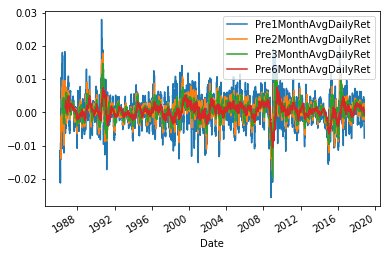

In [31]:
data_OUT2.iloc[:,2:6].plot()
plt.show()

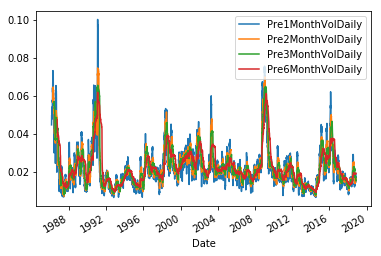

In [32]:
data_OUT2.iloc[:,6:].plot()
plt.show()

Write a function getRange that works with MovingAvg to the range of price movings given a time frame

In [33]:
np.nanmin(data['Daily_Return']['20100101':'20100202'])

-0.021201841531378718

In [34]:
def getRange(series):
    if series.size != 0: # np.nanmin/max cannot work with zero-size array
        return (np.nanmin(series),np.nanmax(series))
    else:
        return np.nan

    

In [35]:
a = getRange(data['Daily_Return']['20100101':'20100202']) # test 
a

(-0.021201841531378718, 0.03762935089369712)

In [36]:
Pre1MonthDailyPriceRange = MovingAvg(data['Daily_Return'],30,getRange,'Pre1MonthDailyPriceRange')
Pre2MonthDailyPriceRange = MovingAvg(data['Daily_Return'],60,getRange,'Pre2MonthDailyPriceRange')
Pre3MonthDailyPriceRange = MovingAvg(data['Daily_Return'],90,getRange,'Pre3MonthDailyPriceRange')
Pre6MonthDailyPriceRange = MovingAvg(data['Daily_Return'],180,getRange,'Pre6MonthDailyPriceRange')

C:\Users\fzhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: All-NaN axis encountered
  This is separate from the ipykernel package so we can avoid doing imports until


In [37]:
Pre1MonthDailyPriceRange.iloc[30:50,:]

,Pre1MonthDailyPriceRange
Date,
1986-02-13,"(-0.10562571756601613, 0.07300771208226231)"
1986-02-14,"(-0.10562571756601613, 0.07300771208226231)"
1986-02-18,"(-0.10562571756601613, 0.07300771208226231)"
1986-02-19,"(-0.10562571756601613, 0.07300771208226231)"
1986-02-20,"(-0.10562571756601613, 0.07300771208226231)"
1986-02-21,"(-0.10562571756601613, 0.07300771208226231)"
1986-02-24,"(-0.10562571756601613, 0.07300771208226231)"
1986-02-25,"(-0.10562571756601613, 0.07703595011005127)"
1986-02-26,"(-0.10562571756601613, 0.07703595011005127)"


In [38]:
data_OUT3 = data_OUT2.join([Pre1MonthDailyPriceRange,Pre2MonthDailyPriceRange,Pre3MonthDailyPriceRange,Pre6MonthDailyPriceRange])
data_OUT3.iloc[1000:1020,:]

,Price,Daily_Return,Pre1MonthAvgDailyRet,Pre2MonthAvgDailyRet,Pre3MonthAvgDailyRet,Pre6MonthAvgDailyRet,Pre1MonthVolDaily,Pre2MonthVolDaily,Pre3MonthVolDaily,Pre6MonthVolDaily,Pre1MonthDailyPriceRange,Pre2MonthDailyPriceRange,Pre3MonthDailyPriceRange,Pre6MonthDailyPriceRange
Date,,,,,,,,,,,,,,
1989-12-04,20.24,-0.000987,0.000685825,0.000199755,0.00115369,3.47191e-05,0.0137083,0.01208,0.0116323,0.0158419,"(-0.03508771929824561, 0.024226804123711476)","(-0.03508771929824561, 0.024226804123711476)","(-0.03508771929824561, 0.024226804123711476)","(-0.05538771399798581, 0.04504504504504503)"
1989-12-05,20.22,-0.000988,0.000115269,0.000153715,0.0011385,7.24438e-05,0.0135153,0.0120807,0.0116344,0.0158337,"(-0.03508771929824561, 0.024226804123711476)","(-0.03508771929824561, 0.024226804123711476)","(-0.03508771929824561, 0.024226804123711476)","(-0.05538771399798581, 0.04504504504504503)"
1989-12-06,20.46,0.011869,6.51141e-05,0.000384393,0.000960325,0.000323435,0.0132066,0.0119614,0.0115768,0.0155558,"(-0.03508771929824561, 0.024226804123711476)","(-0.03508771929824561, 0.024226804123711476)","(-0.03508771929824561, 0.024226804123711476)","(-0.05538771399798581, 0.04504504504504503)"
1989-12-07,20.45,-0.000489,0.000578345,0.000730369,0.000876845,0.000321007,0.0131387,0.0120729,0.0114778,0.015554,"(-0.03508771929824561, 0.024226804123711476)","(-0.03508771929824561, 0.024226804123711476)","(-0.03508771929824561, 0.024226804123711476)","(-0.05538771399798581, 0.04504504504504503)"
1989-12-08,20.41,-0.001956,0.000922459,0.000702661,0.000877252,0.000344431,0.0130019,0.0119363,0.0114778,0.0155505,"(-0.03508771929824561, 0.024226804123711476)","(-0.03508771929824561, 0.024226804123711476)","(-0.03508771929824561, 0.024226804123711476)","(-0.05538771399798581, 0.04504504504504503)"
1989-12-11,20.69,0.013719,0.0019654,0.000300851,0.000553742,0.000551644,0.0129157,0.0119707,0.0112546,0.0153389,"(-0.03508771929824561, 0.024226804123711476)","(-0.03508771929824561, 0.024226804123711476)","(-0.03508771929824561, 0.024226804123711476)","(-0.05538771399798581, 0.04504504504504503)"
1989-12-12,20.80,0.005317,0.00208472,0.000654413,0.0007648,0.00057766,0.0130118,0.0121361,0.0113702,0.0153583,"(-0.03508771929824561, 0.024226804123711476)","(-0.03508771929824561, 0.024226804123711476)","(-0.03508771929824561, 0.024226804123711476)","(-0.05538771399798581, 0.04504504504504503)"
1989-12-13,20.75,-0.002404,0.00223162,0.000420805,0.00091663,0.000273018,0.0127305,0.0119459,0.0113641,0.0148636,"(-0.03508771929824561, 0.024226804123711476)","(-0.03508771929824561, 0.024226804123711476)","(-0.03508771929824561, 0.024226804123711476)","(-0.05538771399798581, 0.04504504504504503)"
1989-12-14,20.67,-0.003855,0.00203008,-0.000111792,0.000731117,0.000182078,0.0124865,0.0115427,0.0113183,0.0148438,"(-0.03508771929824561, 0.024226804123711476)","(-0.03508771929824561, 0.024226804123711476)","(-0.03508771929824561, 0.024226804123711476)","(-0.05538771399798581, 0.04504504504504503)"


# Y calculation

In [39]:
next1MonthAvgDailyRet = MovingAvg(data['Daily_Return'],30,np.nanmean,'next1MonthAvgDailyRet',pre=False)
next1MonthVolDaily = MovingAvg(data['Daily_Return'],30,np.nanstd,'next1MonthVolDaily',pre=False)
next2MonthAvgDailyRet = MovingAvg(data['Daily_Return'],60,np.nanmean,'next2MonthAvgDailyRet',pre=False)
next2MonthVolDaily = MovingAvg(data['Daily_Return'],60,np.nanstd,'next2MonthVolDaily',pre=False)
next3MonthAvgDailyRet = MovingAvg(data['Daily_Return'],90,np.nanmean,'next3MonthAvgDailyRet',pre=False)
next3MonthVolDaily = MovingAvg(data['Daily_Return'],90,np.nanstd,'next3MonthVolDaily',pre=False)
next6MonthAvgDailyRet = MovingAvg(data['Daily_Return'],180,np.nanmean,'next6MonthAvgDailyRet',pre=False)
next6MonthVolDaily = MovingAvg(data['Daily_Return'],180,np.nanstd,'next6MonthVolDaily',pre=False)

C:\Users\fzhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
C:\Users\fzhan\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1545: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


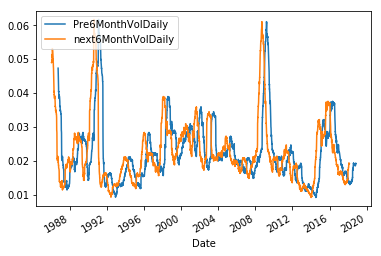

In [40]:
Pre6MonthVolDaily.join(next6MonthVolDaily).plot()
plt.show()

In [41]:
data_OUT4 = data_OUT3.join([next1MonthAvgDailyRet,next2MonthAvgDailyRet,next3MonthAvgDailyRet,next6MonthAvgDailyRet,
                next1MonthVolDaily,next2MonthVolDaily,next3MonthVolDaily,next6MonthVolDaily])
data_OUT4.iloc[70:100,:]

,Price,Daily_Return,Pre1MonthAvgDailyRet,Pre2MonthAvgDailyRet,Pre3MonthAvgDailyRet,Pre6MonthAvgDailyRet,Pre1MonthVolDaily,Pre2MonthVolDaily,Pre3MonthVolDaily,Pre6MonthVolDaily,...,Pre3MonthDailyPriceRange,Pre6MonthDailyPriceRange,next1MonthAvgDailyRet,next2MonthAvgDailyRet,next3MonthAvgDailyRet,next6MonthAvgDailyRet,next1MonthVolDaily,next2MonthVolDaily,next3MonthVolDaily,next6MonthVolDaily
Date,,,,,,,,,,,,,,,,,,,,,
1986-04-14,12.94,-0.050624,0.00634561,-0.00231575,NaN,NaN,0.0690974,0.06315,NaN,NaN,...,NaN,NaN,0.00907724,0.00240556,-0.00155169,0.00196909,0.0368783,0.0411855,0.0371498,0.0402677
1986-04-15,12.72,-0.017002,0.00401284,-0.00274146,NaN,NaN,0.0701853,0.0634148,NaN,NaN,...,NaN,NaN,0.0109256,0.00286763,-0.000405486,0.00212085,0.0365891,0.0415626,0.0377644,0.0403925
1986-04-16,11.50,-0.095912,0.00301215,-0.00422534,NaN,NaN,0.0686398,0.0630181,NaN,NaN,...,NaN,NaN,0.0157818,0.00484136,0.00222871,0.00265851,0.0292781,0.0386943,0.0367858,0.0395219
1986-04-17,11.75,0.021739,-0.0014844,-0.00597086,NaN,NaN,0.070156,0.0645244,NaN,NaN,...,NaN,NaN,0.0154982,0.00432376,0.00140795,0.00263855,0.0299375,0.0386101,0.036918,0.0395129
1986-04-18,11.88,0.011064,-0.00314022,-0.00531109,NaN,NaN,0.0691513,0.0638914,NaN,NaN,...,NaN,NaN,0.0180808,0.00400801,0.00187758,0.0023882,0.0317293,0.0386079,0.0372247,0.0395579
1986-04-21,12.48,0.050505,-0.0010583,-0.00307221,NaN,NaN,0.0699337,0.0627686,NaN,NaN,...,NaN,NaN,0.0115826,0.00413068,0.00141073,0.00216035,0.0349773,0.0381958,0.0367939,0.0393616
1986-04-22,13.13,0.052083,-0.00323893,-0.00248519,NaN,NaN,0.0675721,0.0631505,NaN,NaN,...,NaN,NaN,0.0117847,0.00298895,-0.00207566,0.00191607,0.0352234,0.0379157,0.0418816,0.0391452
1986-04-23,13.70,0.043412,-0.000604535,0.000254826,NaN,NaN,0.0669877,0.0629618,NaN,NaN,...,NaN,NaN,0.0103471,0.00131228,-0.00283768,0.00159514,0.0353489,0.0376472,0.0414818,0.0389677
1986-04-24,13.65,-0.003650,0.00139622,0.00213096,NaN,NaN,0.0660867,0.0630458,NaN,NaN,...,NaN,NaN,0.0110136,0.00128055,-0.00260387,0.00142986,0.0360455,0.0376519,0.0415181,0.0390334


In [43]:
data_OUT4.to_csv('Step1_RawY_variable_and_processing.csv')
data_OUT4.to_pickle("Step1_RawY_variable_and_processing.pkl")